In [11]:
import torch
import matplotlib.pyplot as plt
import time

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

torch.manual_seed(0)

Using device: cpu


In [13]:
k = 10
steps = 1000
runs = 2000


In [14]:
def run_bandit(strategy, name):
    avg_rewards = torch.zeros(steps, device=device)
    start_time = time.time()

    for run in range(runs):
        q_true = torch.randn(k, device=device)
        q_est = torch.zeros(k, device=device)
        counts = torch.zeros(k, device=device)

        for t in range(steps):
           
            if strategy["type"] == "egreedy":
                if torch.rand((), device=device) < strategy["eps"]:
                    action = torch.randint(0, k, (), device=device).item()
                else:
                    action = torch.argmax(q_est).item()

            elif strategy["type"] == "ucb":
                if (counts == 0).any():
                    action = torch.argmin(counts).item()
                else:
                    ucb = q_est + strategy["c"] * torch.sqrt(
                        torch.log(torch.tensor(t + 1.0, device=device)) / counts
                    )
                    action = torch.argmax(ucb).item()

            
            reward = torch.randn((), device=device) + q_true[action]

            
            counts[action] += 1
            q_est[action] += (reward - q_est[action]) / counts[action]
            avg_rewards[t] += reward

            
            if (run % 200 == 0) and (t % 200 == 0):
                print(
                    f"[{name}] Run {run+1}/{runs}, "
                    f"Step {t+1}/{steps}"
                )

    elapsed = time.time() - start_time
    print(f"[{name}] Finished in {elapsed:.2f} seconds\n")

    return (avg_rewards / runs).cpu()



In [15]:
def optimistic_initialization():
    avg_rewards = torch.zeros(steps, device=device)
    start_time = time.time()

    for run in range(runs):
        q_true = torch.randn(k, device=device)
        q_est = torch.ones(k, device=device) * 5.0
        counts = torch.zeros(k, device=device)

        for t in range(steps):
            action = torch.argmax(q_est).item()
            reward = torch.randn((), device=device) + q_true[action]

            counts[action] += 1
            q_est[action] += (reward - q_est[action]) / counts[action]
            avg_rewards[t] += reward

            if (run % 200 == 0) and (t % 200 == 0):
                print(
                    f"[Optimistic Init] Run {run+1}/{runs}, "
                    f"Step {t+1}/{steps}"
                )

    elapsed = time.time() - start_time
    print(f"[Optimistic Init] Finished in {elapsed:.2f} seconds\n")

    return (avg_rewards / runs).cpu()

In [16]:
strategies = {
    "Greedy ε=0": {"type": "egreedy", "eps": 0.0},
    "ε=0.01": {"type": "egreedy", "eps": 0.01},
    "ε=0.1": {"type": "egreedy", "eps": 0.1},
    "UCB c=2": {"type": "ucb", "c": 2},
}

results = {}

for name, strat in strategies.items():
    print(f"\nStarting strategy: {name}")
    results[name] = run_bandit(strat, name)

print("\nStarting strategy: Optimistic Initialization")
results["Optimistic Init"] = optimistic_initialization()


Starting strategy: Greedy ε=0
[Greedy ε=0] Run 1/2000, Step 1/1000
[Greedy ε=0] Run 1/2000, Step 201/1000
[Greedy ε=0] Run 1/2000, Step 401/1000
[Greedy ε=0] Run 1/2000, Step 601/1000
[Greedy ε=0] Run 1/2000, Step 801/1000
[Greedy ε=0] Run 201/2000, Step 1/1000
[Greedy ε=0] Run 201/2000, Step 201/1000
[Greedy ε=0] Run 201/2000, Step 401/1000
[Greedy ε=0] Run 201/2000, Step 601/1000
[Greedy ε=0] Run 201/2000, Step 801/1000
[Greedy ε=0] Run 401/2000, Step 1/1000
[Greedy ε=0] Run 401/2000, Step 201/1000
[Greedy ε=0] Run 401/2000, Step 401/1000
[Greedy ε=0] Run 401/2000, Step 601/1000
[Greedy ε=0] Run 401/2000, Step 801/1000
[Greedy ε=0] Run 601/2000, Step 1/1000
[Greedy ε=0] Run 601/2000, Step 201/1000
[Greedy ε=0] Run 601/2000, Step 401/1000
[Greedy ε=0] Run 601/2000, Step 601/1000
[Greedy ε=0] Run 601/2000, Step 801/1000
[Greedy ε=0] Run 801/2000, Step 1/1000
[Greedy ε=0] Run 801/2000, Step 201/1000
[Greedy ε=0] Run 801/2000, Step 401/1000
[Greedy ε=0] Run 801/2000, Step 601/1000
[Gree

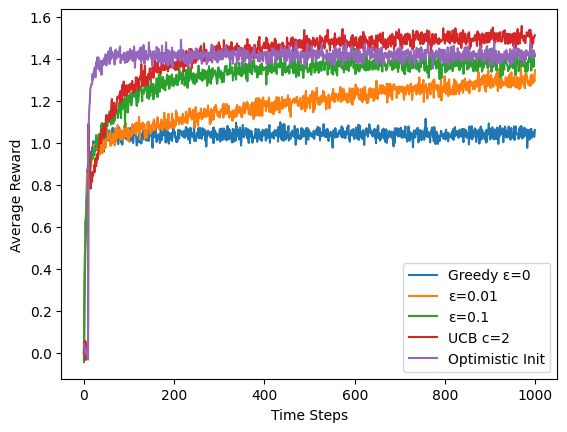

In [17]:
plt.figure()
for name, rewards in results.items():
    plt.plot(rewards, label=name)

plt.xlabel("Time Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.show()
